<a href="https://colab.research.google.com/github/bhardwajharsh07/Anime-Recommendation-System/blob/main/Anime_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING REQUIRED LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import html
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, MinMaxScaler
from sklearn.neighbors import NearestNeighbors

# IMPORTING DATASET

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Supervised ML/Anime Recommendation System Project (KNN)/anime.csv')
df.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


# DATASET DESCRIPTION

The dataset used in this project contains structured information about a large collection of anime titles. Each row represents a single anime with metadata describing its content, popularity, and user ratings. It was sourced from MyAnimeList.net and downloaded from kaggle.

Link: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database

Columns Description

* anime_id: A unique identifier assigned to each anime.

* name: The official title of the anime.

* genre: A comma-separated list of genres describing the show (e.g., Action, Comedy, Fantasy).

* type: The format of the anime (TV, Movie, OVA, ONA, Special, Music).

* episodes: Total number of episodes; varies significantly across anime types.

* rating: Average user rating (on a 10-point scale).

* members: The number of users who marked the anime as watched or planned to watch—a measure of popularity.

## Number of rows and Columns

In [3]:
print(f"Number of Rows: {df.shape[0]}\nNumber of Columns: {df.shape[1]}")

Number of Rows: 12294
Number of Columns: 7


## Created a function named 'matrix' which gives the current information about our dataframe

In [4]:
def matrix(data):
    features = []
    count = []
    duplicates = []
    missing  = []
    modes = []
    duplicate_percentage = []
    missing_percentage = []
    dtype = []
    for i in data.columns:
        features.append(i)
        count.append(data[i].count())
        duplicates.append(data.duplicated(subset=[i]).sum())
        missing.append(data[i].isnull().sum())
        modes.append(data[i].mode()[0])
        duplicate_percentage.append(f"{(data.duplicated(subset=[i]).sum())/data.shape[0]*100:.2f} %")
        missing_percentage.append(f"{(data[i].isnull().sum())/data.shape[0]*100:.2f} %")
        dtype.append(data[i].dtype)

    dataFrame = pd.DataFrame({'Features/Columns' : features,
                              'Count' : count,
                              'Missing' : missing,
                              'Duplicates' : duplicates,
                              'Mode' : modes,
                              'Duplicate Percentage' : duplicate_percentage,
                              'Missing Percentage' : missing_percentage,
                              'Data Type' : dtype})
    return dataFrame


matrix(df)

,Features/Columns,Count,Missing,Duplicates,Mode,Duplicate Percentage,Missing Percentage,Data Type
0,anime_id,12294,0,0,1,0.00 %,0.00 %,int64
1,name,12294,0,2,Saru Kani Gassen,0.02 %,0.00 %,object
2,genre,12232,62,9029,Hentai,73.44 %,0.50 %,object
3,type,12269,25,12287,TV,99.94 %,0.20 %,object
4,episodes,12294,0,12106,1,98.47 %,0.00 %,object
5,rating,12064,230,11695,6.0,95.13 %,1.87 %,float64
6,members,12294,0,5588,60,45.45 %,0.00 %,int64


# DATA CLEANING

## Cleaning the 'name' column

In [5]:
# 1. Decode HTML entities
df["name"] = df["name"].apply(lambda x: html.unescape(x))

# 2. Fix encoding issues (Ã©, Ã¡, Â°, etc.)
df["name"] = df["name"].str.encode("latin1", errors="ignore").str.decode("utf-8", errors="ignore")

# 3. Normalize unicode
df["name"] = df["name"].apply(lambda x: unicodedata.normalize("NFKC", x))

# 4. Cleanup whitespace
df["name"] = df["name"].str.strip()
df["name"] = df["name"].str.replace(r"\s+", " ", regex=True)

## Cleaning the 'genre' column

In [6]:
# df = df.dropna(subset=["genre"])

df["genre"] = df["genre"].fillna("Unknown")

df['genre'] = df['genre'].str.replace('Hentai', 'Adult')

## Filling missing values in the 'type' column with keyword 'Unknown'

In [7]:
# df = df.dropna(subset=["type"])

df["type"] = df["type"].fillna("Unknown")

## Filling missing values anf then changing the datatype of the 'episodes' column

In [8]:
df["episodes"] = df["episodes"].replace("Unknown",None)

df["episodes"] = pd.to_numeric(df["episodes"], errors='coerce')

df["episodes"] = df["episodes"].fillna(0)

df["episodes"] = df["episodes"].astype(int)

## Imputing missing values in 'rating' using its median

In [9]:
# df = df.dropna(subset=["rating"])

df["rating"] = df["rating"].fillna(df["rating"].median())

In [10]:
matrix(df)

,Features/Columns,Count,Missing,Duplicates,Mode,Duplicate Percentage,Missing Percentage,Data Type
0,anime_id,12294,0,0,1,0.00 %,0.00 %,int64
1,name,12294,0,7,Gintama,0.06 %,0.00 %,object
2,genre,12294,0,9029,Adult,73.44 %,0.00 %,object
3,type,12294,0,12287,TV,99.94 %,0.00 %,object
4,episodes,12294,0,12106,1,98.47 %,0.00 %,int64
5,rating,12294,0,11696,6.57,95.14 %,0.00 %,float64
6,members,12294,0,5588,60,45.45 %,0.00 %,int64


# EXPLORATORY DATA ANALYSIS

## Description of 'Numerical' columns

In [11]:
df.describe()

,anime_id,episodes,rating,members
count,12294.000000,12294.000000,12294.000000,1.229400e+04
mean,14058.221653,12.102652,6.475700,1.807134e+04
std,11455.294701,46.758239,1.017179,5.482068e+04
min,1.000000,0.000000,1.670000,5.000000e+00
25%,3484.250000,1.000000,5.900000,2.250000e+02
50%,10260.500000,2.000000,6.570000,1.550000e+03
75%,24794.500000,12.000000,7.170000,9.437000e+03
max,34527.000000,1818.000000,10.000000,1.013917e+06


## Rating

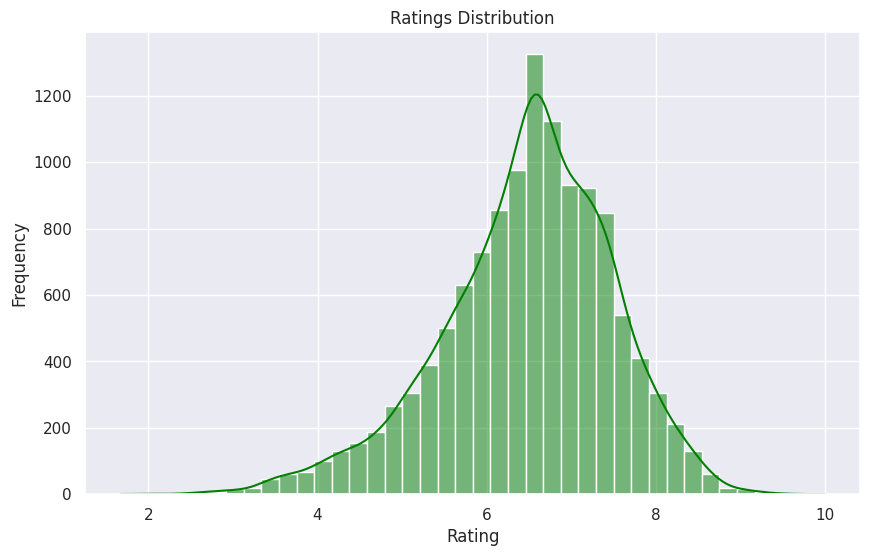

In [12]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(10,6))
sns.histplot(df['rating'], bins=40, color='green', kde=True)
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [13]:
print(f"The most rated anime: \n")
df.nlargest(10,'rating')[['name','rating','genre','type','episodes']]

The most rated anime: 



,name,rating,genre,type,episodes
10464,Taka no Tsume 8: Yoshida-kun no X-Files,10.00,"Comedy, Parody",Movie,1
10400,Spoon-hime no Swing Kitchen,9.60,"Adventure, Kids",TV,0
9595,Mogura no Motoro,9.50,Slice of Life,Movie,1
0,Kimi no Na wa.,9.37,"Drama, Romance, School, Supernatural",Movie,1
9078,Kahei no Umi,9.33,Historical,Movie,1
1,Fullmetal Alchemist: Brotherhood,9.26,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64
2,Gintama,9.25,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51
10786,Yakusoku: Africa Mizu to Midori,9.25,"Drama, Kids",OVA,1
3,Steins;Gate,9.17,"Sci-Fi, Thriller",TV,24
4,Gintama',9.16,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51


In [14]:
print(f"Anime with the lowest ratings: \n")
df.nsmallest(10,'rating')[['name','rating','genre','type','episodes']]

Anime with the lowest ratings: 



,name,rating,genre,type,episodes
9991,Platonic Chain: Ansatsu Jikkouchuu,1.67,"Sci-Fi, Slice of Life",Special,1
12258,Hi Gekiga Ukiyoe Senya Ichiya,1.92,"Action, Adult",Movie,1
8058,Tenkuu Danzai Skelter+Heaven,2.00,"Mecha, Sci-Fi",OVA,1
8057,Utsu Musume Sayuri,2.14,"Comedy, Dementia",OVA,1
8056,Hametsu no Mars,2.37,"Horror, Sci-Fi",OVA,1
10087,Roboteuwang Sseonsyakeu,2.49,"Action, Mecha, Sci-Fi",Movie,1
9516,Mechano: Scientific Attack Force,2.55,"Comedy, Dementia, Fantasy, Horror, Music, Parody",OVA,3
8289,Cakes,2.58,Comedy,ONA,0
8054,Kokuhaku,2.67,Horror,ONA,1
8055,Nami,2.67,Dementia,Movie,1


## Episodes

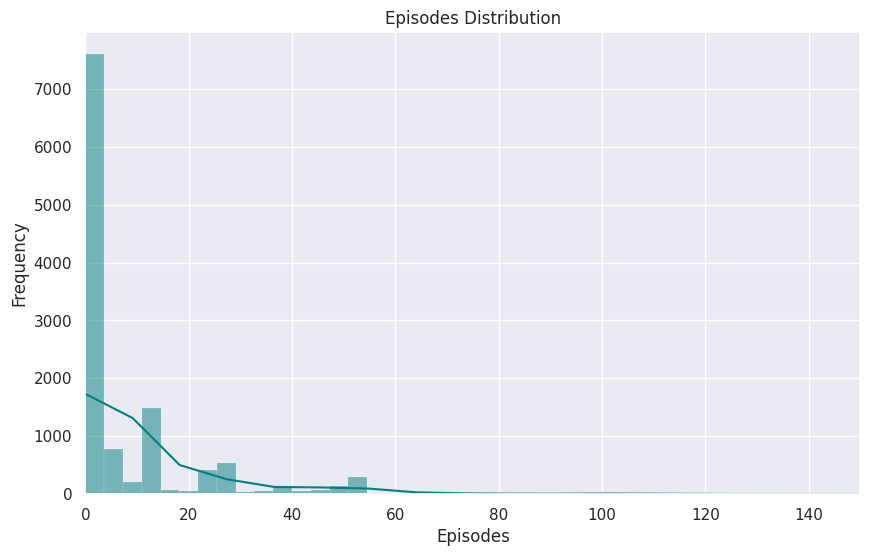

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(df['episodes'], bins=500, color='teal', kde=True)
plt.xlim(0,150)
plt.title('Episodes Distribution')
plt.xlabel('Episodes')
plt.ylabel('Frequency')
plt.show()

In [16]:
print(f"Number of Anime with episodes greater that 150 is: {df[df['episodes'] > 150].shape[0]}\n")

Number of Anime with episodes greater that 150 is: 82



In [17]:
# pd.set_option('display.max_rows', None)

print(f"The list is as follows:\n")
df[df['episodes'] > 150][['name','episodes']]

The list is as follows:



,name,episodes
12,Gintama,201
74,One Piece,769
175,Katekyo Hitman Reborn!,203
206,Dragon Ball Z,291
288,Fairy Tail,175
...,...,...
9979,Pinch to Punch,156
10165,Sekai Monoshiri Ryoko,1006
10306,Sobakasu Pucchi,162
10518,Tetsujin 28-gou Gao!,151


In [18]:
# pd.reset_option('display.max_rows')

In [19]:
df.nlargest(7, 'episodes')[['name', 'episodes', 'type']]

,name,episodes,type
6296,Oyako Club,1818,TV
929,Doraemon (1979),1787,TV
9243,Kirin Monoshiri Yakata,1565,TV
5360,Manga Nippon Mukashibanashi (1976),1471,TV
6580,Hoka Hoka Kazoku,1428,TV
9242,Kirin Ashita no Calendar,1306,TV
9613,Monoshiri Daigaku: Ashita no Calendar,1274,TV


## Type

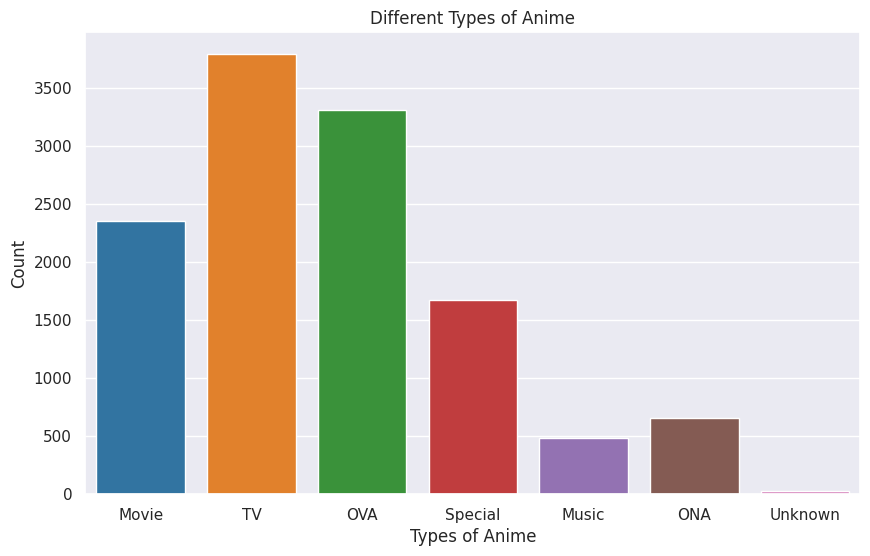

In [20]:
plt.figure(figsize=(10,6))
sns.countplot(x=df['type'], palette='tab10')
plt.title('Different Types of Anime')
plt.xlabel('Types of Anime')
plt.ylabel('Count')
plt.show()

In [21]:
df['type'].value_counts()

,count
type,
TV,3787
OVA,3311
Movie,2348
Special,1676
ONA,659
Music,488
Unknown,25


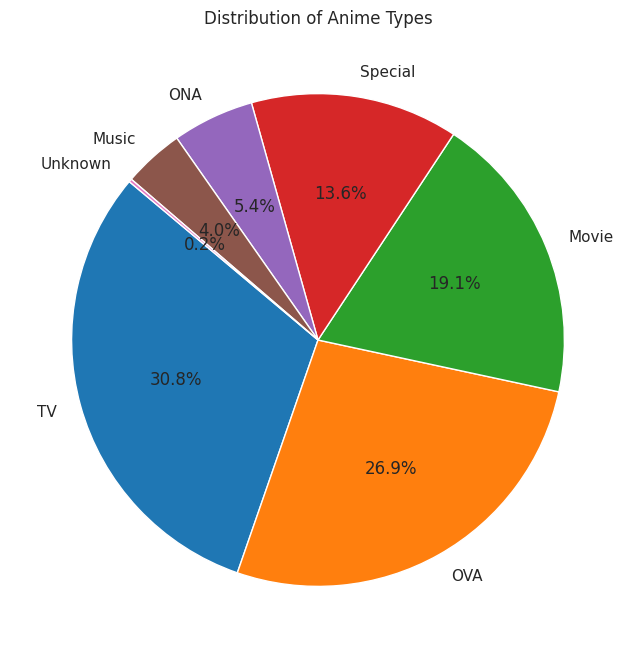

In [22]:
type_counts = df["type"].value_counts()

plt.figure(figsize=(8, 8))
colors = sns.color_palette("tab10", len(type_counts))
plt.pie(type_counts,labels=type_counts.index,autopct='%1.1f%%',startangle=140,colors=colors)
plt.title("Distribution of Anime Types")
plt.show()

## Members

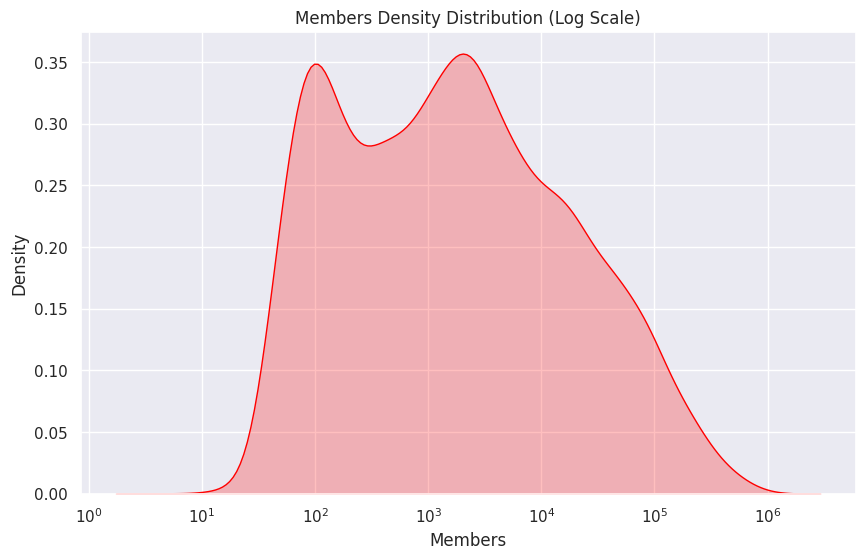

In [23]:
plt.figure(figsize=(10,6))
sns.kdeplot(df['members'], fill=True, color='red', log_scale=True)
plt.title('Members Density Distribution (Log Scale)')
plt.xlabel('Members')
plt.ylabel('Density')
plt.show()

In [24]:
df.nlargest(7,'members')[['name','members','type','genre','rating']]

,name,members,type,genre,rating
40,Death Note,1013917,TV,"Mystery, Police, Psychological, Supernatural, ...",8.71
86,Shingeki no Kyojin,896229,TV,"Action, Drama, Fantasy, Shounen, Super Power",8.54
804,Sword Art Online,893100,TV,"Action, Adventure, Fantasy, Game, Romance",7.83
1,Fullmetal Alchemist: Brotherhood,793665,TV,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.26
159,Angel Beats!,717796,TV,"Action, Comedy, Drama, School, Supernatural",8.39
19,Code Geass: Hangyaku no Lelouch,715151,TV,"Action, Mecha, Military, School, Sci-Fi, Super...",8.83
841,Naruto,683297,TV,"Action, Comedy, Martial Arts, Shounen, Super P...",7.81


In [25]:
df.nsmallest(7,'members')[['name','members','type','genre','rating']]

,name,members,type,genre,rating
10997,Gou-chan. Moko to Chinjuu no Mori no Nakama-tachi,5,Movie,"Adventure, Kids",6.57
10990,Ganko-chan,11,Unknown,Unknown,6.57
10444,Sushi Azarashi,12,TV,Comedy,3.00
10424,Suijun Genten,13,Movie,Unknown,7.00
10464,Taka no Tsume 8: Yoshida-kun no X-Files,13,Movie,"Comedy, Parody",10.00
10719,Wareware no Heya,15,Movie,Unknown,8.00
8367,"Chotto Ugoku!? ""Futeneko""",17,OVA,Comedy,6.00


## Correlation Heatmap of Numerical Features

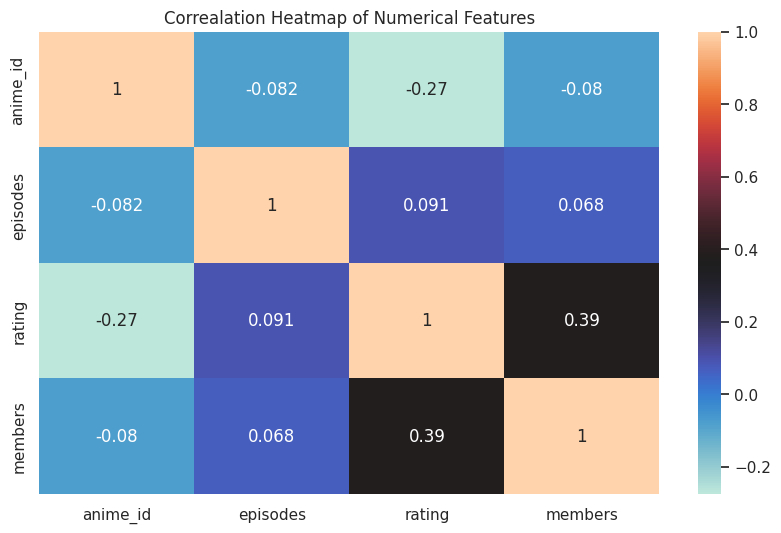

In [26]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['anime_id','episodes','rating','members']].corr(), annot=True, cmap='icefire')
plt.title('Correalation Heatmap of Numerical Features')
plt.show()

# FEATURE ENGINEERING AND PREPROCESSING

## Multi-Hot Encoding the 'genre' column

In [27]:
df["genre_list"] = df["genre"].apply(lambda x: x.split(", "))

mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df["genre_list"])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=df.index)

## One-Hot Encoding the 'type' column

In [28]:
onehotencoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
type_encoded = onehotencoder.fit_transform(df[["type"]])
type_df = pd.DataFrame(type_encoded,columns=onehotencoder.get_feature_names_out(["type"]),index=df.index)

## Log tranformation of 'members' column and scaling the required numerical features

In [29]:
df["members_log"] = np.log1p(df["members"])

scaler = MinMaxScaler()
numeric_scaled = scaler.fit_transform(df[["episodes", "rating", "members_log"]])
numeric_df = pd.DataFrame(numeric_scaled,columns=["episodes_scaled","rating_scaled","members_scaled"],index=df.index)

## Final Feature Matrix

In [30]:
final_features = np.hstack([
    genre_df.values*2,
    type_df.values*1.5,
    numeric_df[["episodes_scaled"]].values*0.5,
    numeric_df[["rating_scaled"]].values*2,
    numeric_df[["members_scaled"]].values*1
])

In [31]:
final_features.shape

(12294, 54)

# MACHINE LEARNING MODEL (KNN)

## Calling KNN model and fitting the final features matrix

In [32]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(final_features)

NearestNeighbors(algorithm='brute', metric='cosine')

## Function to recommend anime based on given anime name and number of recommendations

In [33]:
def recommend(anime, num_recommendations=10):
    if anime not in df["name"].values:
        return f"Anime '{anime}' not found."

    anime_index = df.index[df["name"] == anime][0]

    distances, indices = knn.kneighbors([final_features[anime_index]], n_neighbors=num_recommendations + 1)
    recommendations = df.iloc[indices[0][1:]]

    return recommendations[["name", "genre", "type", "rating", "members"]]

In [34]:
recommend("Haikyuu!!", 20)

,name,genre,type,rating,members
14,Haikyuu!! Second Season,"Comedy, Drama, School, Shounen, Sports",TV,8.93,179342
79,Slam Dunk,"Comedy, Drama, School, Shounen, Sports",TV,8.56,82570
5,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,9.15,93351
72,Kuroko no Basket 2nd Season,"Comedy, School, Shounen, Sports",TV,8.58,243325
58,Kuroko no Basket 3rd Season,"Comedy, School, Shounen, Sports",TV,8.62,184525
122,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,8.46,338315
20,Hajime no Ippo,"Comedy, Drama, Shounen, Sports",TV,8.83,157670
32,Hajime no Ippo: New Challenger,"Comedy, Drama, Shounen, Sports",TV,8.75,88995
44,Hajime no Ippo: Rising,"Comedy, Drama, Shounen, Sports",TV,8.68,66756
254,Diamond no Ace,"Comedy, School, Shounen, Sports",TV,8.25,81384


In [35]:
recommend("Death Note", 1)

,name,genre,type,rating,members
981,Mousou Dairinin,"Drama, Mystery, Police, Psychological, Superna...",TV,7.74,137687


In [36]:
recommend("K-On!", 15)

,name,genre,type,rating,members
373,K-On!!,"Comedy, Music, School, Slice of Life",TV,8.14,246276
1065,Love Live! School Idol Project,"Music, School, Slice of Life",TV,7.70,155281
452,Azumanga Daioh,"Comedy, School, Slice of Life",TV,8.06,170901
839,Minami-ke,"Comedy, School, Slice of Life",TV,7.81,105471
418,Tanaka-kun wa Itsumo Kedaruge,"Comedy, School, Slice of Life",TV,8.10,101335
459,Love Live! School Idol Project 2nd Season,"Music, School, Slice of Life",TV,8.06,91864
1623,GJ-bu,"Comedy, School, Slice of Life",TV,7.48,83838
97,Nichijou,"Comedy, School, Slice of Life",TV,8.52,254436
1803,Tari Tari,"Music, School, Slice of Life",TV,7.44,80960
1001,Mitsudomoe,"Comedy, School, Slice of Life",TV,7.73,56483


## Evaluating model based on distance from given anime

In [37]:
def evaluate_model(anime):
    if anime not in df["name"].values:
        return "Anime not found."

    index = df.index[df["name"] == anime][0]
    distances, indices = knn.kneighbors([final_features[index]], n_neighbors=11)

    print("Target Anime: ",anime)
    print("\nNearest Distances:")
    result = []
    for d, idx in zip(distances[0][1:],indices[0][1:]):
        result.append({
            "distance": round(float(d), 4),
            "name": df.iloc[idx]["name"],
            "type":df.iloc[idx].get("type",None),
            "genre": df.iloc[idx].get("genre", None)
        })
    return pd.DataFrame(result)

In [38]:
evaluate_model('Shingeki no Kyojin')

Target Anime:  Shingeki no Kyojin

Nearest Distances:


,distance,name,type,genre
0,0.0043,Shingeki no Kyojin Season 2,TV,"Action, Drama, Fantasy, Shounen, Super Power"
1,0.0890,Shingeki no Kyojin OVA,OVA,"Action, Drama, Fantasy, Shounen, Super Power"
2,0.0907,Shingeki no Kyojin Movie 1: Guren no Yumiya,Movie,"Action, Drama, Fantasy, Shounen, Super Power"
3,0.0907,Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa,Movie,"Action, Drama, Fantasy, Shounen, Super Power"
4,0.0929,Shingeki no Kyojin: Ano Hi Kara,Special,"Action, Drama, Fantasy, Shounen, Super Power"
5,0.1265,One Piece,TV,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
6,0.1710,Utawarerumono: Itsuwari no Kamen,TV,"Action, Drama, Fantasy"
7,0.1734,Juushin Enbu: Hero Tales,TV,"Action, Fantasy, Shounen"
8,0.1743,Wei Kreuz,TV,"Action, Drama, Shounen"
9,0.1756,X-Men,TV,"Action, Drama, Super Power"


In [39]:
evaluate_model('Yahari Ore no Seishun Love Comedy wa Machigatteiru.')

Target Anime:  Yahari Ore no Seishun Love Comedy wa Machigatteiru.

Nearest Distances:


,distance,name,type,genre
0,0.0001,Yahari Ore no Seishun Love Comedy wa Machigatt...,TV,"Comedy, Drama, Romance, School"
1,0.0008,Kotoura-san,TV,"Comedy, Drama, Romance, School"
2,0.0017,Otome wa Boku ni Koishiteru,TV,"Comedy, Drama, Romance, School"
3,0.0812,Sakurasou no Pet na Kanojo,TV,"Comedy, Drama, Romance, School, Slice of Life"
4,0.0822,Chuunibyou demo Koi ga Shitai!,TV,"Comedy, Drama, Romance, School, Slice of Life"
5,0.0824,Cross Game,TV,"Comedy, Drama, Romance, School, Sports"
6,0.0837,Chuunibyou demo Koi ga Shitai! Ren,TV,"Comedy, Drama, Romance, School, Slice of Life"
7,0.0852,OnegaiTeacher,TV,"Comedy, Drama, Romance, School, Sci-Fi"
8,0.0884,I My Me! Strawberry Eggs,TV,"Comedy, Drama, Romance, School, Slice of Life"
9,0.0884,Tonagura!,TV,"Comedy, Drama, Ecchi, Romance, School"


In [40]:
evaluate_model('Inazuma Eleven')

Target Anime:  Inazuma Eleven

Nearest Distances:


,distance,name,type,genre
0,0.0004,Inazuma Eleven Go,TV,"Shounen, Sports, Super Power"
1,0.0004,Inazuma Eleven Go: Chrono Stone,TV,"Shounen, Sports, Super Power"
2,0.0010,Inazuma Eleven Go: Galaxy,TV,"Shounen, Sports, Super Power"
3,0.1264,Over Drive,TV,"Shounen, Sports"
4,0.1265,Grappler Baki (TV),TV,"Shounen, Sports"
5,0.1268,Ginga e Kickoff!!,TV,"Shounen, Sports"
6,0.1285,Buzzer Beater,TV,"Shounen, Sports"
7,0.1290,Gekitou! Crush Gear Turbo,TV,"Shounen, Sports"
8,0.1297,Chousoku Spinner,TV,"Shounen, Sports"
9,0.1297,Musashi no Ken,TV,"Shounen, Sports"
